In [2]:
%matplotlib inline

In [37]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from sithcon import SITHCon_Layer, _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob
ttype=torch.cuda.FloatTensor
import numpy as np
import pandas as pd
import pickle
from math import factorial
import random
import matplotlib.patches as patches
from itertools import combinations_with_replacement as comb


<class 'torch.cuda.FloatTensor'>


In [4]:
# SHORTER
MORSE_CODE_DICT = {'1':'.-', '2':'-...', 
                    '3':'-.-.', '4':'-..', '5':'.', 
                    '6':'..-.', '7':'--.', '8':'....', 
                    '9':'..', '0':'.---',}

In [6]:
morse_code_numpy = {key:np.array([int(x) for x in MORSE_CODE_DICT[key].replace('.', '10').replace('-', '1110')] + [0, 0])
                    for key in MORSE_CODE_DICT.keys()}
for k in morse_code_numpy.keys():
    print(morse_code_numpy[k], k)
subset = list(morse_code_numpy.keys())


[1 0 1 1 1 0 0 0] 1
[1 1 1 0 1 0 1 0 1 0 0 0] 2
[1 1 1 0 1 0 1 1 1 0 1 0 0 0] 3
[1 1 1 0 1 0 1 0 0 0] 4
[1 0 0 0] 5
[1 0 1 0 1 1 1 0 1 0 0 0] 6
[1 1 1 0 1 1 1 0 1 0 0 0] 7
[1 0 1 0 1 0 1 0 0 0] 8
[1 0 1 0 0 0] 9
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 0


(590, 2)


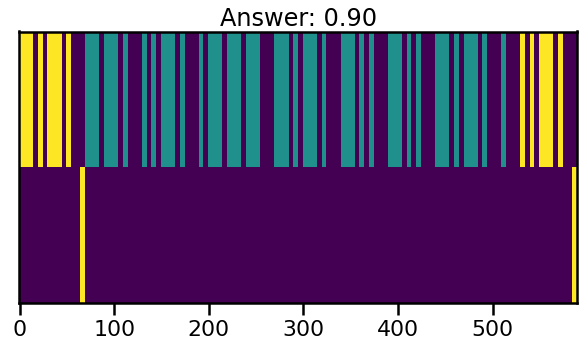

In [32]:
def gen_item(samples=10, scale=5, target_scale=.1, display=False):
    # We can tests 1s the same length as the items added together or 1 at the end only.
    keys = morse_code_numpy.keys()
    dim1 = []
    dim2 = []
    half = int(samples / 2)
    added_indexes = [np.random.randint(half),  
                     np.random.randint(half, samples)]
    
    answer = 0
    for s in range(samples):
        # Grab Random Morse Code Letter
        k = random.sample(keys, 1)[0]
        mcl = morse_code_numpy[k]
        Mmcl = mcl.repeat(scale)
        dim1.append(Mmcl[:, np.newaxis])
        if s in added_indexes:
            
            # dim2.append(np.ones(Mmcl.shape[0])[:, np.newaxis])
            temp = np.zeros(Mmcl.shape[0])[:, np.newaxis]
            temp[-scale:] = 1.0
            if display:
                    temp = temp * 2.0
            #temp[-1] = 1.0 # TRY THIS AT SOME POINT
            dim2.append(temp)
            answer += int(k)
            if display:
                dim1[-1] = dim1[-1]*2.0
        else:
            dim2.append(np.zeros(Mmcl.shape[0])[:, np.newaxis])
    inp = np.concatenate([np.concatenate(dim1, axis=0),
                          np.concatenate(dim2, axis=0)], axis=1)
    
    target = np.array([answer])
    return inp, target*target_scale
inp, tar = gen_item(10, 5, .1, display=True)
print(inp.shape)
plt.figure(figsize=(10,5))
plt.imshow(inp.T,aspect='auto', interpolation='none')
plt.title("Answer: {:.2f}".format(tar[0]))
plt.yticks([])
plt.savefig(join('figs', 'adding_morse_example'), dpi=100)

In [8]:
class SITHCon_Classifier(nn.Module):
    def __init__(self, out_classes, layer_params, 
                 act_func=nn.ReLU, batch_norm=False,
                 dropout=.2):
        super(SITHCon_Classifier, self).__init__()
        last_channels = layer_params[-1]['channels']
        self.transform_linears = nn.ModuleList([nn.Linear(l['channels'], l['channels'])
                                                for l in layer_params])
        self.sithcon_layers = nn.ModuleList([SITHCon_Layer(l, act_func) for l in layer_params])
        self.to_out = nn.Linear(last_channels, out_classes)
        
        
    def forward(self, inp):
        
        x = inp
        #out = []
        for i in range(len(self.sithcon_layers)):
            x = self.sithcon_layers[i](x)
            
            x = F.relu(self.transform_linears[i](x[:,0,:,:].transpose(1,2)))
            x = x.unsqueeze(1).transpose(2,3)

            #out.append(x.clone())
        x = x.transpose(2,3)[:, 0, :, :]
        #x = x.transpose(2,3)[:, 0, :, :]
        x = self.to_out(x)
        return x

# Three Layers

In [ ]:
params = [
           [400, 35, 23, 2],]

In [13]:
def gen_model(p):
    sp1 = dict(in_features=2, 
               tau_min=.1, tau_max=3000, buff_max=6000,
               dt=1, ntau=p[0], k=p[1], g=0.0, ttype=ttype, 
               channels=25, kernel_width=p[2], dilation=p[3],
               dropout=None, batch_norm=None)
    sp2 = dict(in_features=sp1['channels'], 
               tau_min=.1, tau_max=3000, buff_max=6000,
               dt=1, ntau=p[0], k=p[1], g=0.0, ttype=ttype, 
               channels=25, kernel_width=p[2], dilation=p[3], 
               dropout=None, batch_norm=None)
    sp3 = dict(in_features=sp2['channels'], 
               tau_min=.1, tau_max=3000, buff_max=6000,
               dt=1, ntau=p[0], k=p[1], g=0.0, ttype=ttype, 
               channels=25, kernel_width=p[2], dilation=p[3], 
               dropout=None, batch_norm=None)
    layer_params = [sp1, sp2, sp3]
    model = SITHCon_Classifier(1, layer_params, act_func=None#nn.ReLU
                              ).cuda()
    return model

def test_model(model, X, Y):
    model.eval()
    evald = []
    evaldDict = {'test_perf':[],
                 'rate':[],
                 'tau_max':[],
                 'ntau':[],
                 'k':[]}
    
    # BIG NOTE
    # BIG NOTE
    # BIG NOTE
    # Generate the test items once, use in all models at all scales. 
    model.eval()
    evald = []
    evaldDict = {'test_perf':[],
                 'rate':[]}
    for nr in range(1,20):
        losses = []
        for iv, tar in items:

            iv = ttype(iv).unsqueeze(0).unsqueeze(0).transpose(-1,-2).unsqueeze(-1)
            iv = iv.repeat(1,1,1,1,nr)
            iv = iv.reshape(1,1,2,-1)
            tv = torch.FloatTensor(tar).to(device)
            out = model(iv)

            loss = loss_func(out[:, -1, :],
                                 tv)
            losses.append(loss.detach().cpu().numpy())
        print(nr, np.mean(losses))
        evaldDict['test_perf'].append(np.mean(losses))
        evaldDict['rate'].append(nr)
        evaldDict['tau_max'].append(model.sithcon_layers[0].sithcon.sith.tau_max)
        evaldDict['ntau'].append(model.sithcon_layers[0].sithcon.sith.ntau)
        evaldDict['k'].append(model.sithcon_layers[0].sithcon.sith.k)
    return evaldDict

def save_outcome(outcome, filename):
    dat = pd.DataFrame(outcome)
    dat.to_csv(join('perf',filename))

In [14]:
params = [
           [400, 35, 23, 2],]

In [15]:
model = gen_model(params[0])
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

Total Weights: 31951
SITHCon_Classifier(
  (transform_linears): ModuleList(
    (0): Linear(in_features=25, out_features=25, bias=True)
    (1): Linear(in_features=25, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=25, bias=True)
  )
  (sithcon_layers): ModuleList(
    (0): SITHCon_Layer(
      (sithcon): _SITHCon_Core(
        (sith): iSITH(ntau=400, tau_min=0.1, tau_max=3000, buff_max=6000, dt=1, k=35, g=0.0)
        (conv): Conv2d(1, 25, kernel_size=(2, 23), stride=(1, 1), dilation=(1, 2), bias=False)
        (maxp): MaxPool1d(kernel_size=356, stride=356, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): SITHCon_Layer(
      (sithcon): _SITHCon_Core(
        (sith): iSITH(ntau=400, tau_min=0.1, tau_max=3000, buff_max=6000, dt=1, k=35, g=0.0)
        (conv): Conv2d(1, 25, kernel_size=(25, 23), stride=(1, 1), dilation=(1, 2), bias=False)
        (maxp): MaxPool1d(kernel_size=356, stride=356, padding=0, dilation=1, ceil_mode=False)
      )
    )
 

In [16]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

Trainscale = 5
epochs = 500
trials_per_epoch = 1000
batch_size = 32
device='cuda'
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

for epoch_idx in progress_bar:
    perfs = []
    losses = []
    model.train()
    for batch_idx in range(trials_per_epoch):
        optimizer.zero_grad()
        loss = 0
        for i in range(batch_size):
            iv, tar = gen_item(10,Trainscale, .1)
            iv = ttype(iv).unsqueeze(0).unsqueeze(0).transpose(-1,-2)
            tv = ttype(tar)
            out = model(iv)
            loss += loss_func(out[:, -1, :],
                             tv)
        loss = loss / batch_size
        loss.backward()
        optimizer.step()
        
        perfs.append(0)
        #perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        #losses = losses[int(-loss_buffer_size/batch_size):]
        
        
        s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
        format_list = [epoch_idx, batch_idx, np.mean(losses), 
                       np.sum(perfs)/((len(perfs)))]
        s = s.format(*format_list)
        progress_bar.set_description(s)

KeyboardInterrupt: 

# Test

In [17]:
torch.save(model.state_dict(), join('perf', 'SITHCon_MorseAdding_5032021.pt'))

In [263]:
"""
items = []
for i in range(1000):
    iv, tar = gen_item(10, 1, .1)
    items.append([iv, tar])
np.save('generated_adding_morse',items)"""


"\nitems = []\nfor i in range(1000):\n    iv, tar = gen_item(10, 1, .1)\n    items.append([iv, tar])\nnp.save('generated_adding_morse',items)"

In [19]:
items = np.load('generated_adding_morse.npy', allow_pickle=True)

In [37]:
iv = ttype(items[0][0]).unsqueeze(0).unsqueeze(0).transpose(-1,-2).unsqueeze(-1)
iv = iv.repeat(1,1,1,1,10)
iv = iv.reshape(1,1,2,-1)
print(iv.shape)

torch.Size([1, 1, 2, 1060])


In [20]:
# Generate the test items once, use in all models at all scales. 
model.eval()
evald = []
evaldDict = {'test_perf':[],
             'rate':[]}
for nr in range(1,20):
    losses = []
    for iv, tar in items:

        iv = ttype(iv).unsqueeze(0).unsqueeze(0).transpose(-1,-2).unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,nr)
        iv = iv.reshape(1,1,2,-1)
        tv = torch.FloatTensor(tar).to(device)
        out = model(iv)
        
        loss = loss_func(out[:, -1, :],
                             tv)
        losses.append(loss.detach().cpu().numpy())
    print(nr, np.mean(losses))
    evaldDict['test_perf'].append(np.mean(losses))
    evaldDict['rate'].append(nr)
    evald.append([nr, np.mean(losses)])
scale_perfs = pd.DataFrame(evaldDict)
scale_perfs.to_pickle(join("perf", "sithcon_morseadding_test.dill"))

1 0.6112955
2 0.06855858
3 0.006122265
4 0.00092172256
5 0.0006655243
6 0.00090690027
7 0.0013174565
8 0.0017585462
9 0.002253249
10 0.0026680403
11 0.0030457373
12 0.0033665963
13 0.0036153258
14 0.003826497
15 0.0040139435
16 0.0042847726
17 0.004658794
18 0.005225148
19 0.005907


   test_perf  rate
0   0.611296     1
1   0.068559     2
2   0.006122     3
3   0.000922     4
4   0.000666     5


In [66]:
"""display_examples = []
for i in range(5):
    inp, tar = gen_item(10, 1, .1, display=False)
    display_examples.append([inp, tar])"""

In [265]:
with open(join('perf','display_examples.dill'), 'wb') as handle:
    pickle.dump(display_examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [266]:
with open(join('perf','display_examples.dill'), 'rb') as handle:
    display_examples = pickle.load(handle)